In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from Conv1d import Conv1d
from torchviz import make_dot

# Set random seed for reproducibility
torch.manual_seed(0)

# Generate training data: 2 noisy sine curves
n = 3000        # the number of data points
n_step = 30     # the number of time steps
s1 = np.sin(np.pi * 0.06 * np.arange(n)) + np.random.random(n)
s2 = 0.5 * np.sin(np.pi * 0.05 * np.arange(n)) + np.random.random(n)
data = np.vstack([s1, s2]).T  # shape = (3000, 2)

m = np.arange(0, n - n_step)
x_train = np.array([data[i:(i+n_step), :] for i in m])
y_train = np.array([data[i, :] for i in (m + n_step)])

# Convert to PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)


In [2]:
x_train.size()

torch.Size([2970, 30, 2])

In [3]:
n_emb = 20                  # time series embedding size
k_size = 5                  # kernel size
n_kernel = 10               # number of kernels
p_size = 10                 # pooling filter size
n_feat = x_train.shape[-1]  # the number of features

In [4]:
# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.dense = nn.Linear(n_feat, n_emb)
        self.conv = Conv1d(input_dims=n_emb, filters=n_kernel, kernel_size=k_size, padding='same')
        self.pool = nn.AvgPool1d(kernel_size=p_size, stride=1)
        self.flatten = nn.Flatten()
        # Calculate the size after convolution and pooling
        conv_out_size = n_step  # since padding='same'
        pool_out_size = conv_out_size - p_size + 1  # 30 - 10 + 1 = 21
        self.dense_out = nn.Linear(pool_out_size * n_kernel, y_train.shape[1])

    def forward(self, x):
        x = torch.tanh(self.dense(x))  # [batch_size, 30, 2] > [batch_size, 30, 20]
        x = self.conv(x)               # [batch_size, 30, 10]
        x = torch.relu(x)
        x = x.permute(0, 2, 1)        # [batch_size, 10, 30] for AvgPool1d
        x = self.pool(x)               # [batch_size, 10, 21]
        x = x.permute(0, 2, 1)        # [batch_size, 21, 10] (optional, for consistency)
        x = self.flatten(x)            # [batch_size, 21 * 10 = 210]
        x = self.dense_out(x)          # [batch_size, 2]
        return x


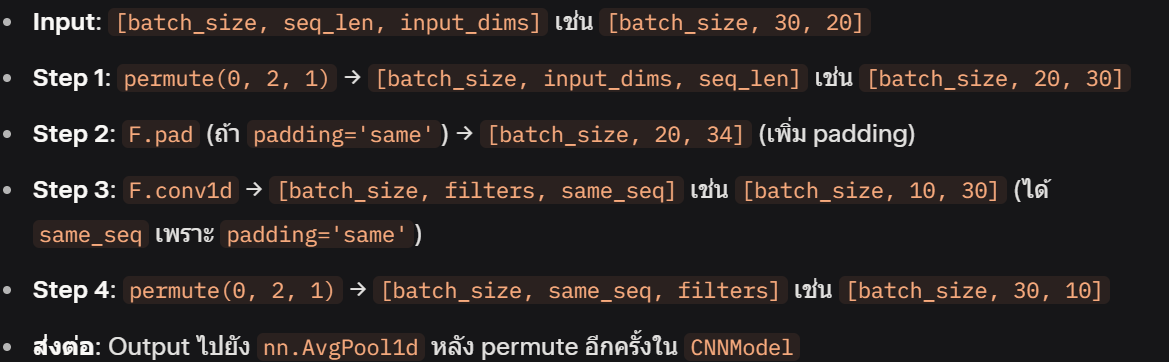

In [5]:
import os 
os.environ["PATH"] += os.pathsep + r"C:\Program Files\Graphviz\bin"  # Adjust if your Graphviz path is different

In [6]:
# Create model and dummy input
model = CNNModel()
dummy_input = torch.randn(32, 30, 2)  # [batch_size=32, seq_len=30, n_feat=2]

# Forward pass and create graph
output = model(dummy_input)
dot = make_dot(output, params=dict(model.named_parameters()), show_attrs=True, show_saved=True)
dot.graph_attr.update(size="10,10", dpi="300")
# Save graph as PNG
dot.render("cnn_model_graph", format="png", cleanup=True)
print("Graph saved as cnn_model_graph.png")

Graph saved as cnn_model_graph.png


In [7]:
# Initialize model, loss function, and optimizer
model = CNNModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Model summary (approximate equivalent to model.summary())
print(model)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")


CNNModel(
  (dense): Linear(in_features=2, out_features=20, bias=True)
  (conv): Conv1d()
  (pool): AvgPool1d(kernel_size=(10,), stride=(1,), padding=(0,))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense_out): Linear(in_features=210, out_features=2, bias=True)
)
Total number of parameters: 1492


In [8]:
# Training
num_epochs = 200
batch_size = 100
loss_history = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for i in range(0, len(x_train), batch_size):
        batch_x = x_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]
        
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / (len(x_train) // batch_size + 1)
    loss_history.append(avg_loss)
    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}')


C:\Users\eieiz\AppData\Local\Temp\ipykernel_28596\3431635711.py:19: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Scalar.cpp:23.)
  total_loss += loss.item()


Epoch [20/200], Loss: 0.098099
Epoch [40/200], Loss: 0.094211
Epoch [60/200], Loss: 0.092114
Epoch [80/200], Loss: 0.090836
Epoch [100/200], Loss: 0.090257
Epoch [120/200], Loss: 0.089719
Epoch [140/200], Loss: 0.089172
Epoch [160/200], Loss: 0.088568
Epoch [180/200], Loss: 0.087985
Epoch [200/200], Loss: 0.087525


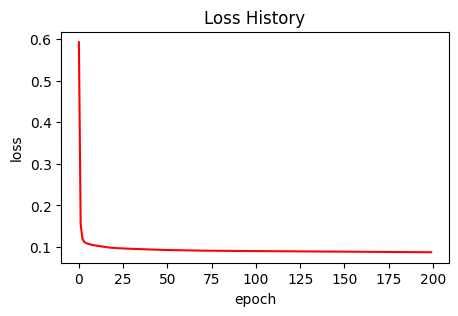

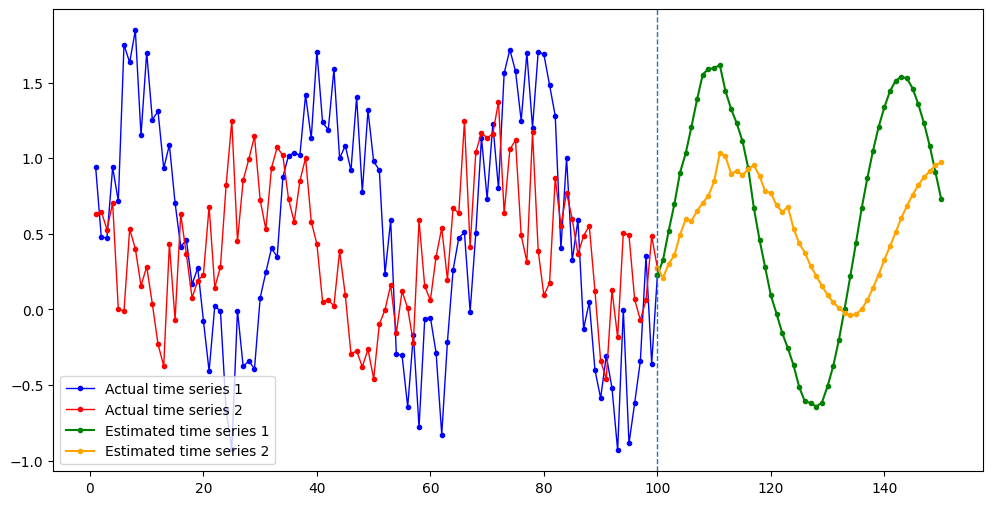

In [9]:
plt.figure(figsize=(5, 3))
plt.plot(loss_history, color='red')
plt.title("Loss History")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

# Predict future values for the next 50 periods
n_future = 50
n_last = 100
last_data = data[-n_last:]  # The last n_last data points
last_data_tensor = torch.tensor(last_data, dtype=torch.float32)

model.eval()
with torch.no_grad():
    for i in range(n_future):
        # Predict the next value with the last n_step data points
        px = last_data_tensor[-n_step:, :].reshape(1, n_step, 2)
        
        # Predict the next value
        y_hat = model(px)
        
        # Append the predicted value to last_data_tensor
        last_data_tensor = torch.cat([last_data_tensor, y_hat], dim=0)

# Convert back to numpy for plotting
last_data = last_data_tensor.numpy()
p = last_data[:-n_future, :]        # past time series
f = last_data[-(n_future + 1):, :]  # future time series

# Plot past and future time series
plt.figure(figsize=(12, 6))
ax1 = np.arange(1, len(p) + 1)
ax2 = np.arange(len(p), len(p) + len(f))
plt.plot(ax1, p[:, 0], '-o', c='blue', markersize=3, 
         label='Actual time series 1', linewidth=1)
plt.plot(ax1, p[:, 1], '-o', c='red', markersize=3, 
         label='Actual time series 2', linewidth=1)
plt.plot(ax2, f[:, 0], '-o', c='green', markersize=3,
         label='Estimated time series 1')
plt.plot(ax2, f[:, 1], '-o', c='orange', markersize=3, 
         label='Estimated time series 2')
plt.axvline(x=ax1[-1], linestyle='dashed', linewidth=1)
plt.legend()
plt.show()